In [14]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
path = "./rossmann-store-sales/"
store = pd.read_csv(f"{path}store.csv", encoding="utf8")
train = pd.read_csv(f"{path}train.csv", encoding="utf8")
test = pd.read_csv(f"{path}test.csv", encoding="utf8")

c:\Users\levan\AppData\Local\Programs\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Dataset Description
You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## Files
* train.csv - historical data including Sales
* test.csv - historical data excluding Sales
* sample_submission.csv - a sample submission file in the correct format
* store.csv - supplemental information about the stores
## Data fields
Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# store.csv Dataset Analysis:

In [5]:
store

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,1111,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


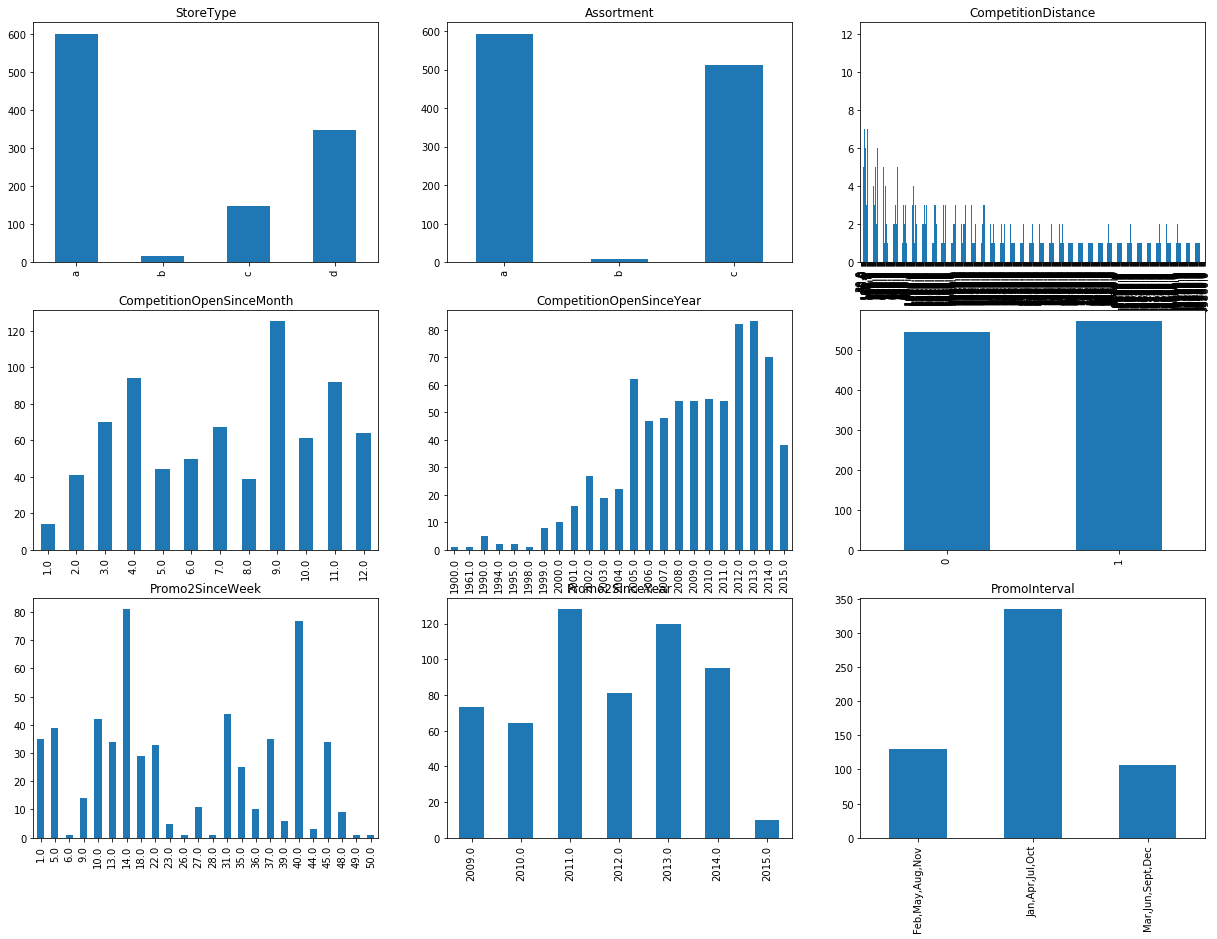

In [36]:
columns = store.copy().drop(store.columns[0], axis=1).columns.values # Drop the first column of the dataframe.

divider = 3
nrows = len(columns)//divider
ncols = divider
fig, ax  = plt.subplots(nrows, ncols, )
fig.set_size_inches(23, 18)
for i in range(len(columns)):
  store[columns[i]].value_counts().sort_index().plot.bar(
    title=columns[i],
    # rot=45,
    ax=ax[i // ncols, i % ncols]
  )

In [6]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


The Train dataset is very large (1M+). Therfore, we should try and find data that is most relevant to our subject.
Let's start by understanding how do holidays effect the results:

In [54]:
holidays_data = train[(train["StateHoliday"] != '0') & (train["StateHoliday"] != 0) & (train["Open"] != 0)].drop("Open", axis=1)
holidays_data  # Now includes only recorded days of stores which were open on holidays.

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
63559,5,4,2015-06-04,5807,625,1,a,0
63560,6,4,2015-06-04,5749,614,1,a,0
63609,55,4,2015-06-04,5984,702,1,a,0
63611,57,4,2015-06-04,9301,870,1,a,0
63614,60,4,2015-06-04,10399,850,1,a,0
...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,0,a,1
1016827,733,2,2013-01-01,10765,2377,0,a,1
1016863,769,2,2013-01-01,5035,1248,0,a,1
1017042,948,2,2013-01-01,4491,1039,0,a,1


In [53]:
len(holidays_data["Store"].unique())

156

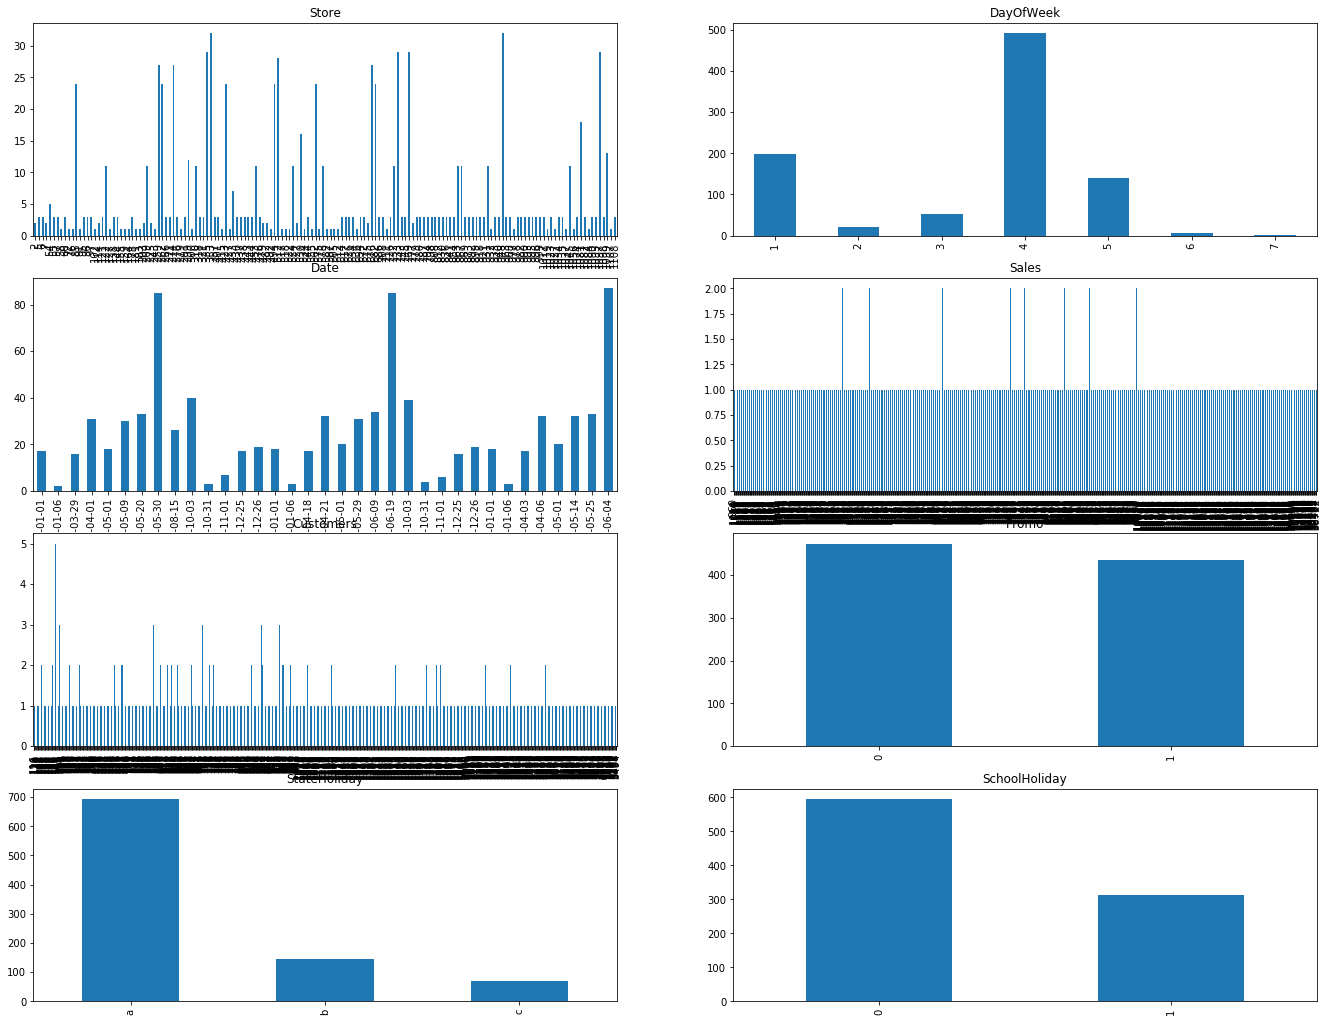

In [55]:
# columns = train.copy().drop(train.columns[0], axis=1).columns.values # Drop the first column of the dataframe.
columns = holidays_data.columns.values # Drop the first column of the dataframe.

divider = 2
nrows = len(columns)//divider
ncols = divider
fig, ax  = plt.subplots(nrows, ncols, )
fig.set_size_inches(23, 18)
for i in range(len(columns)):
  holidays_data[columns[i]].value_counts().sort_index().plot.bar(
    title=columns[i],
    # rot=45,
    ax=ax[i // ncols, i % ncols]
  )

In [7]:
test

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0
...,...,...,...,...,...,...,...,...
41083,41084,1111,6,2015-08-01,1.0,0,0,0
41084,41085,1112,6,2015-08-01,1.0,0,0,0
41085,41086,1113,6,2015-08-01,1.0,0,0,0
41086,41087,1114,6,2015-08-01,1.0,0,0,0
